In [1]:
import os
from collections import defaultdict
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = "../data"
os.listdir(data_dir)

['bus_stops_wszone.dbf',
 'bus_stops_wszone.shp',
 'net_202001_15.net',
 'OD_bus',
 'net_202001_05.net',
 'net_202001_06.net',
 'origin_destination_train_201912.csv.xz',
 'train_station_wszone.prj',
 'origin_destination_train_202001.csv.xz',
 'train_station_wszone.dbf',
 'OD_202001_weekend.csv.xz',
 'net_202001_22.net',
 'subzone_centroid.csv',
 'OD_201912_weekday.csv.xz',
 'origin_destination_bus_201911.csv.xz',
 'net_202001_19.net',
 'net_202001_18.net',
 'train_station_wszone.cpg',
 'OD_PT',
 'train_station_wszone.shx',
 'net_202001_10.net',
 'OD_201911_weekend.csv.xz',
 'origin_destination_train_201911.csv.xz',
 'net_202001_weekend.net',
 'subzone_centroid_pos.json',
 '.ipynb_checkpoints',
 'net_202001_21.net',
 'origin_destination_bus_202001.csv.xz',
 'OD_201912_weekend.csv.xz',
 'net_202001_07.net',
 'origin_destination_bus_201912.csv.xz',
 'net_202001_23.net',
 'region-2014',
 'train_station_wszone.shp',
 'net_202001_weekday.net',
 'net_202001_16.net',
 'OD_train',
 'bus_stops_w

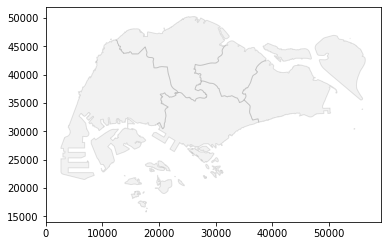

In [4]:
region = gpd.read_file("../data/region-2014/MP14_REGION_WEB_PL.shp")
region.plot(color="grey", edgecolor="k", alpha=0.1)

In [5]:
with open(os.path.join("../data", 'subzone_centroid_pos.json'), 'r') as fread:
    pos = json.load(fread)
pos["MARINA SOUTH"]

[31595.83574613999, 29220.18737674884]

In [6]:
weekday_res = pd.read_csv("Super_SR_weekday.csv", index_col=0)
weekend_res = pd.read_csv("Super_SR_weekend.csv", index_col=0)

In [7]:
weekday_res.head()

,node,cal_dc_spreader,cal_hh,cal_pr_spreader,cal_dc_receiver,cal_ha,cal_pr_receiver
ind,,,,,,,
0,TAMPINES EAST,0.572276,0.572276,0.533376,0.639755,0.635740,0.596268
1,BEDOK NORTH,0.360342,0.337404,0.338292,0.362057,0.340500,0.336666
2,TOA PAYOH CENTRAL,0.624277,0.303357,0.622293,0.631936,0.310269,0.632736
3,ALJUNIED,0.525679,0.322300,0.523547,0.497914,0.331237,0.481654
4,TAMPINES WEST,0.394065,0.431569,0.371555,0.322927,0.394873,0.295054


In [8]:
weekend_res.head()

,node,cal_dc_spreader,cal_hh,cal_pr_spreader,cal_dc_receiver,cal_ha,cal_pr_receiver
ind,,,,,,,
0,TAMPINES EAST,0.554046,0.554046,0.526039,0.602500,0.602500,0.572044
1,BEDOK NORTH,0.435241,0.413180,0.413432,0.433820,0.421214,0.409280
2,TOA PAYOH CENTRAL,0.661196,0.355419,0.666776,0.658458,0.359004,0.670499
3,ALJUNIED,0.490456,0.332743,0.485179,0.443276,0.333933,0.430377
4,TAMPINES WEST,0.318722,0.360123,0.308679,0.287690,0.359133,0.267098


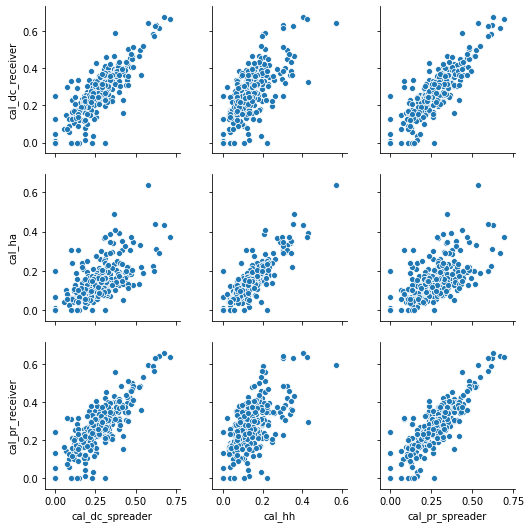

In [17]:
sns.pairplot(weekday_res,  x_vars=["cal_dc_spreader", "cal_hh", "cal_pr_spreader"], y_vars=["cal_dc_receiver","cal_ha","cal_pr_receiver"])

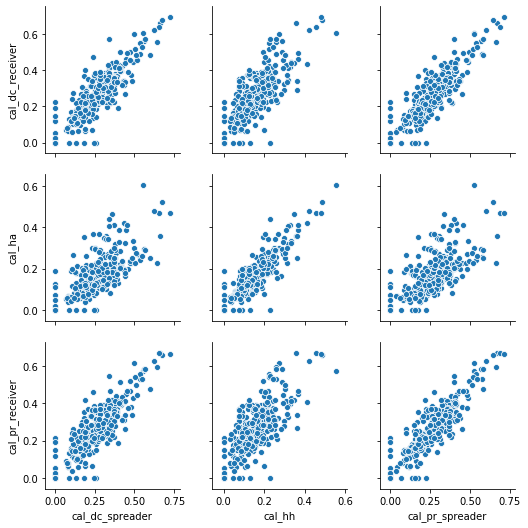

In [18]:
sns.pairplot(weekend_res,  x_vars=["cal_dc_spreader", "cal_hh", "cal_pr_spreader"], y_vars=["cal_dc_receiver","cal_ha","cal_pr_receiver"])

In [10]:
def get_top(df, col, top=10):
    df2 = df[["node", col]].sort_values(by=col, ascending=False)
    nodes = []
    done = False
    i = 0
    while not(done):
        row = df2.iloc[i]
        n = row["node"]
        v = row[col]
        nodes.append((n,v))
        i+=1
        if i>=top:
            if df2.iloc[i][col]!=v:
                done = True
    #print(len(nodes), nodes)
    return nodes
get_top(weekday_res, "cal_dc_spreader")

[('YISHUN CENTRAL', 0.7076367058909477),
 ('WOODLANDS REGIONAL CENTRE', 0.6745677061500274),
 ('JURONG WEST CENTRAL', 0.6439756655766382),
 ('TOA PAYOH CENTRAL', 0.6242768447492224),
 ('YISHUN WEST', 0.6156017032407197),
 ('CHOA CHU KANG CENTRAL', 0.6134705625087508),
 ('JELEBU', 0.6048607669712612),
 ('TAMPINES EAST', 0.5722755128032201),
 ('JURONG GATEWAY', 0.5428506261913704),
 ('YISHUN SOUTH', 0.5305800104939373)]

In [29]:
for col in [ col for col in weekday_res.columns if col!="node"]:
    top_ten = get_top(weekday_res, col)
    print(len(top_ten))
print()
for col in [ col for col in weekend_res.columns if col!="node"]:
    top_ten = get_top(weekend_res, col)
    print(len(top_ten))

10
10
10
10
10
10

10
10
10
10
10
10


In [39]:

def draw_fig(df, col, top=10, top2=0, cat=None):
    top_nodes = get_top(df, col, top=top+top2)
        
    xs = []
    ys = []
    cs = []
    fs = []
    ws = []
    colors = ["red", "blue"]
    for i in range(top+top2):
        n,v = top_nodes[i]
        x,y = pos[n]
        xs.append(x)
        ys.append(y)
        fs.append(v*1000)
        if i<top:
            cs.append(colors[0])
        else:
            cs.append(colors[1])
        
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_aspect("equal")
    region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)
    ax.set_xlim([4500,50000])
    ax.set_ylim([25000,50000])
    ax.scatter(xs, ys, s=fs, color=cs)

    #for i, txt in enumerate(ws):
    #    ax.annotate(txt, (xs[i], ys[i]))
    ax.set_title("{} - {}".format(cat, col))
    plt.tight_layout()
    #plt.savefig("2020-01-weekday-community.png", dpi=100, bbox_inches="tight")

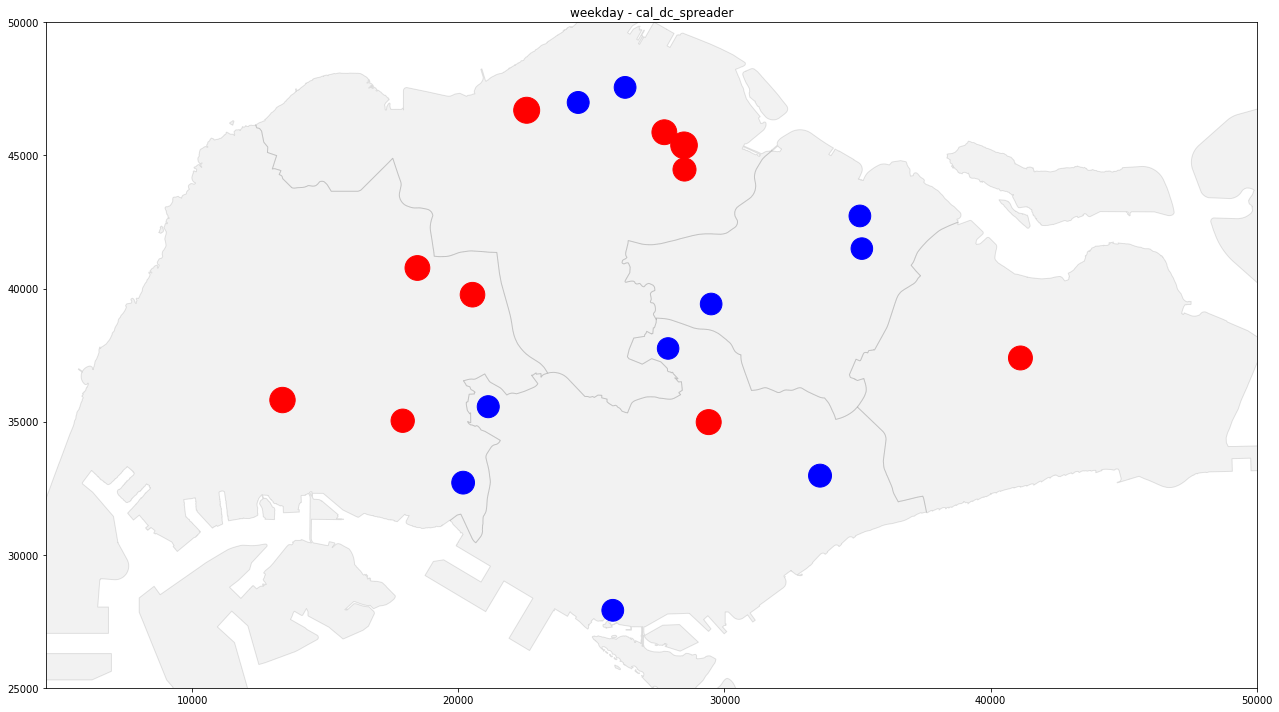

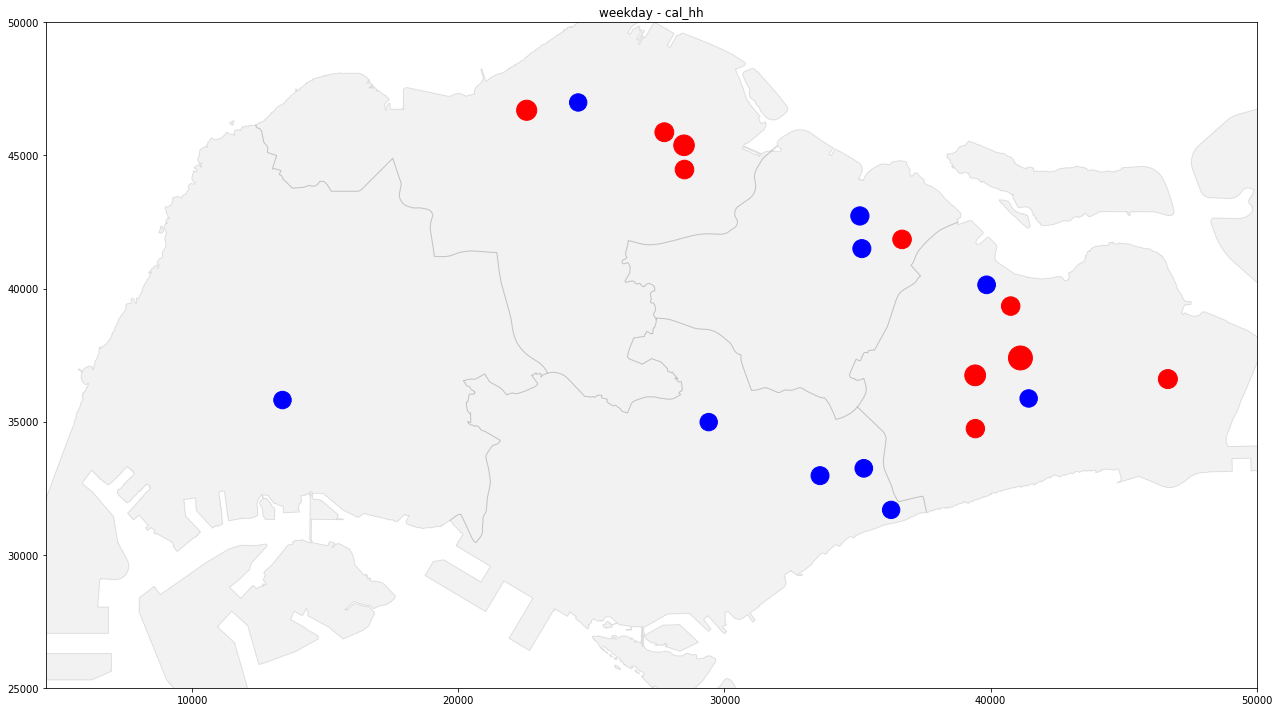

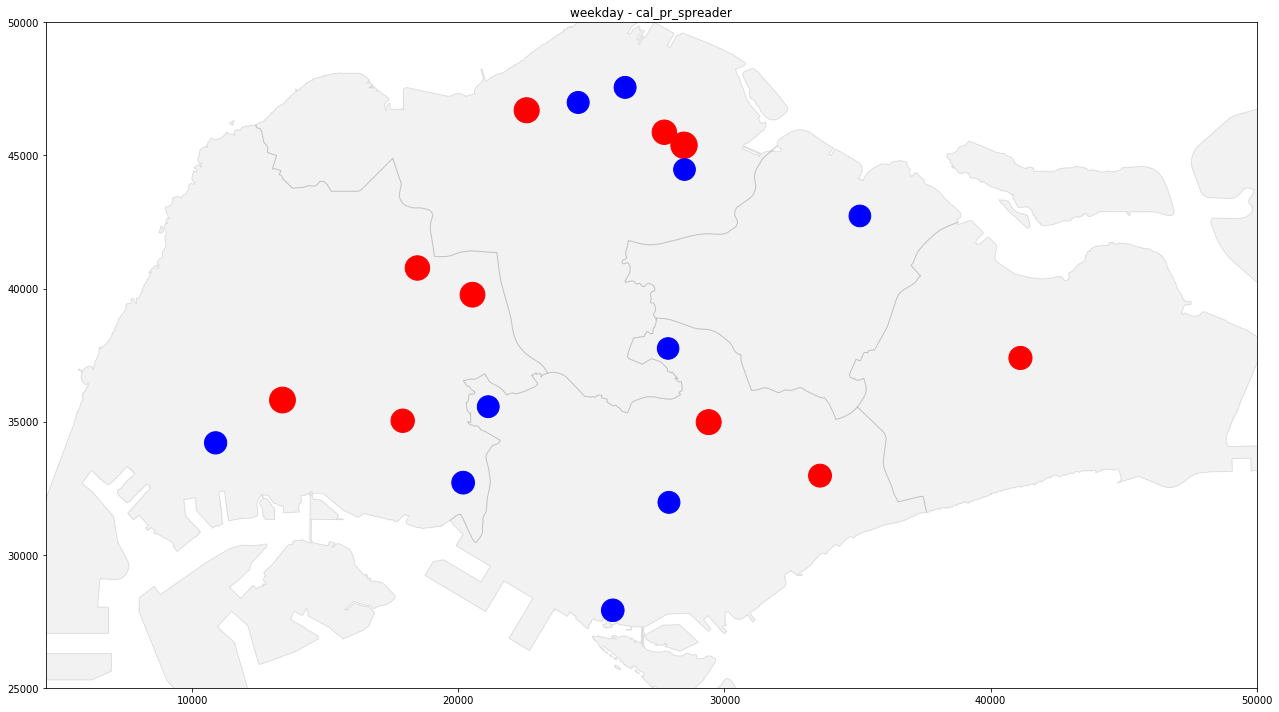

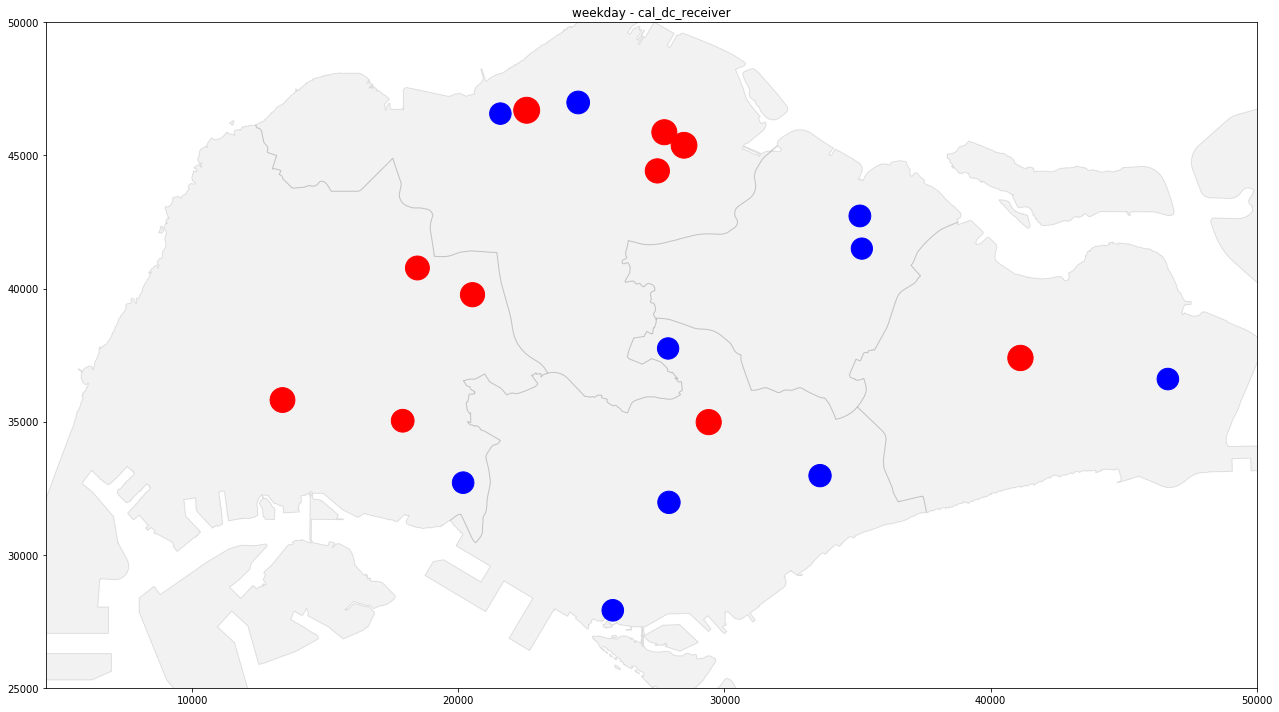

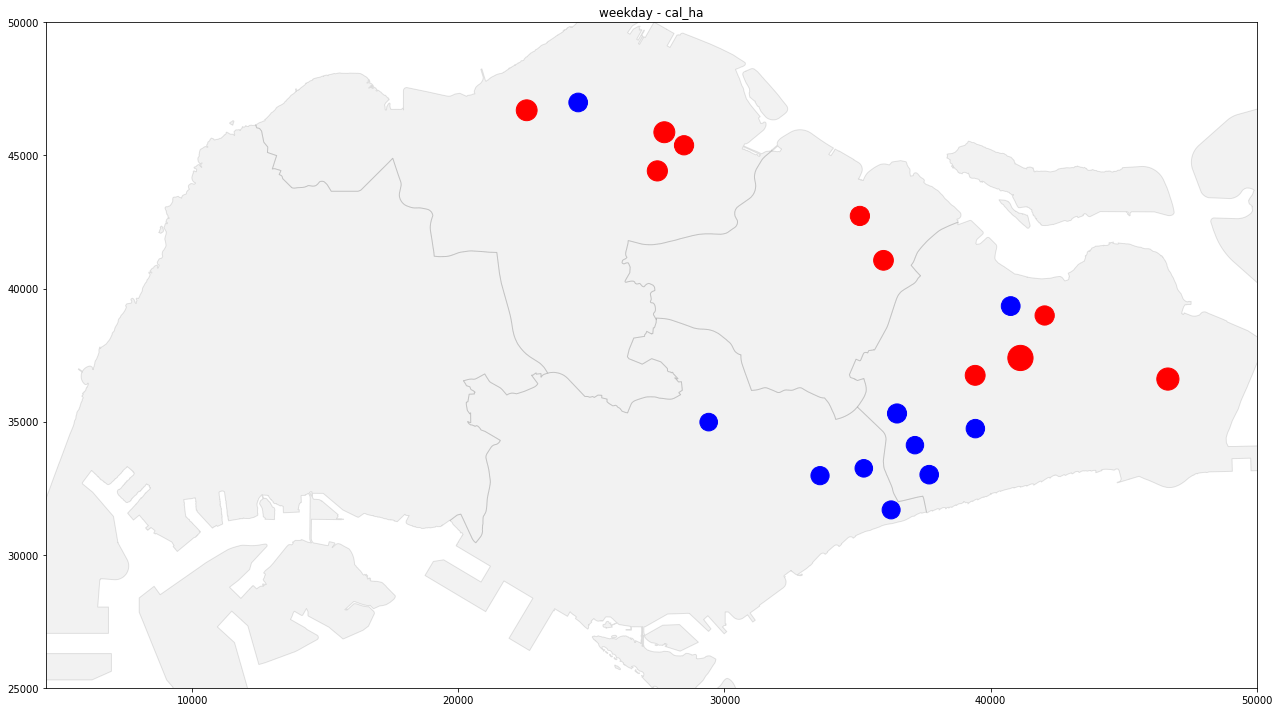

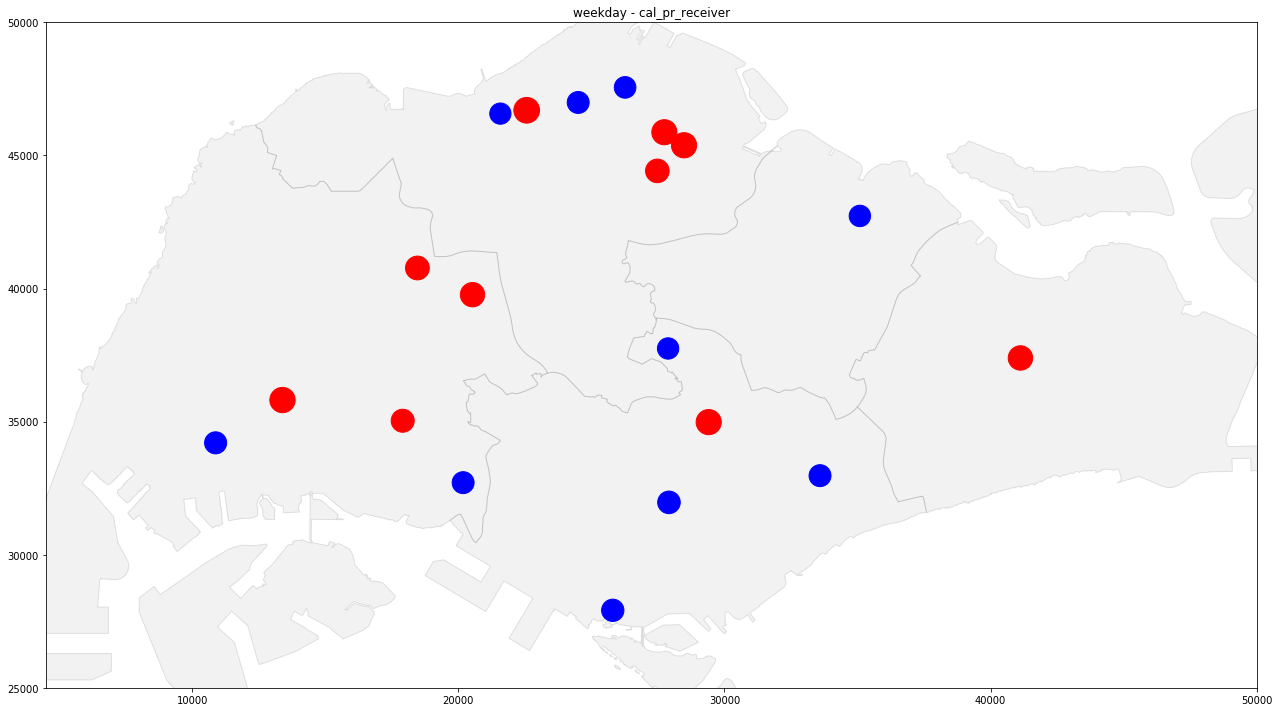

In [40]:
for col in [ col for col in weekday_res.columns if col!="node"]:
    #top_ten = get_top(weekday_res, col)
    draw_fig(weekday_res, col, top=10, top2=10, cat="weekday")

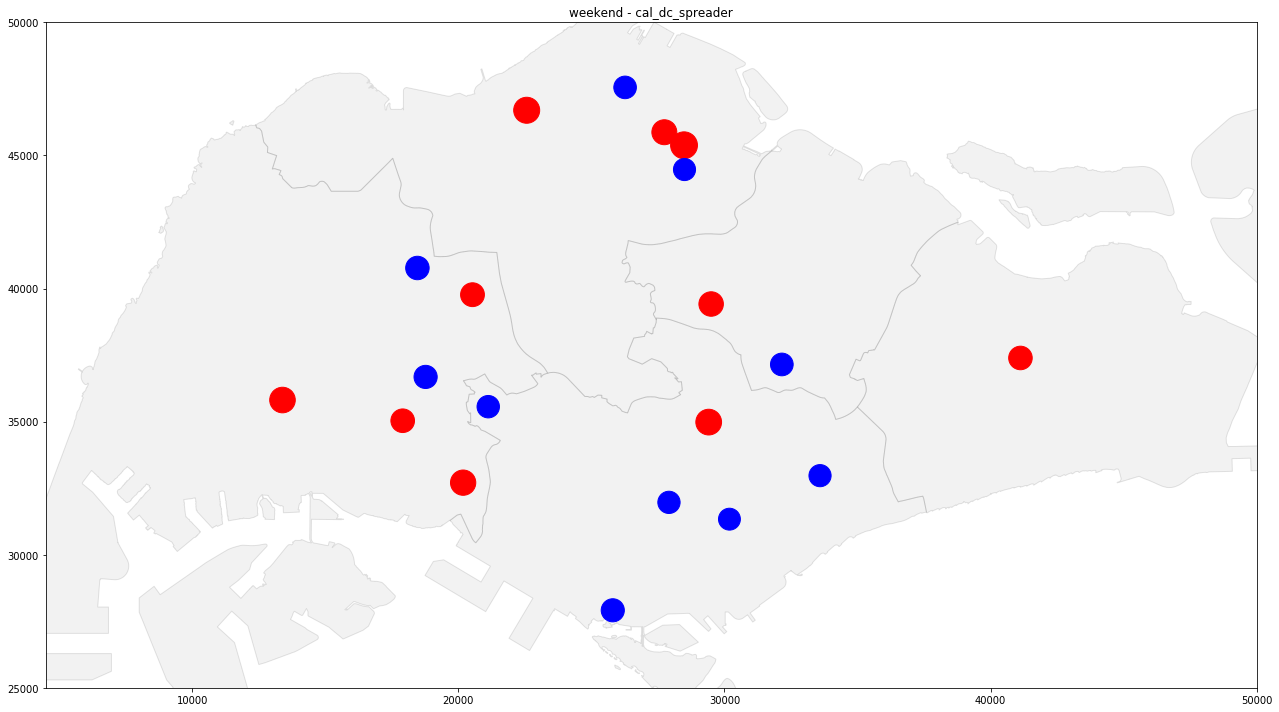

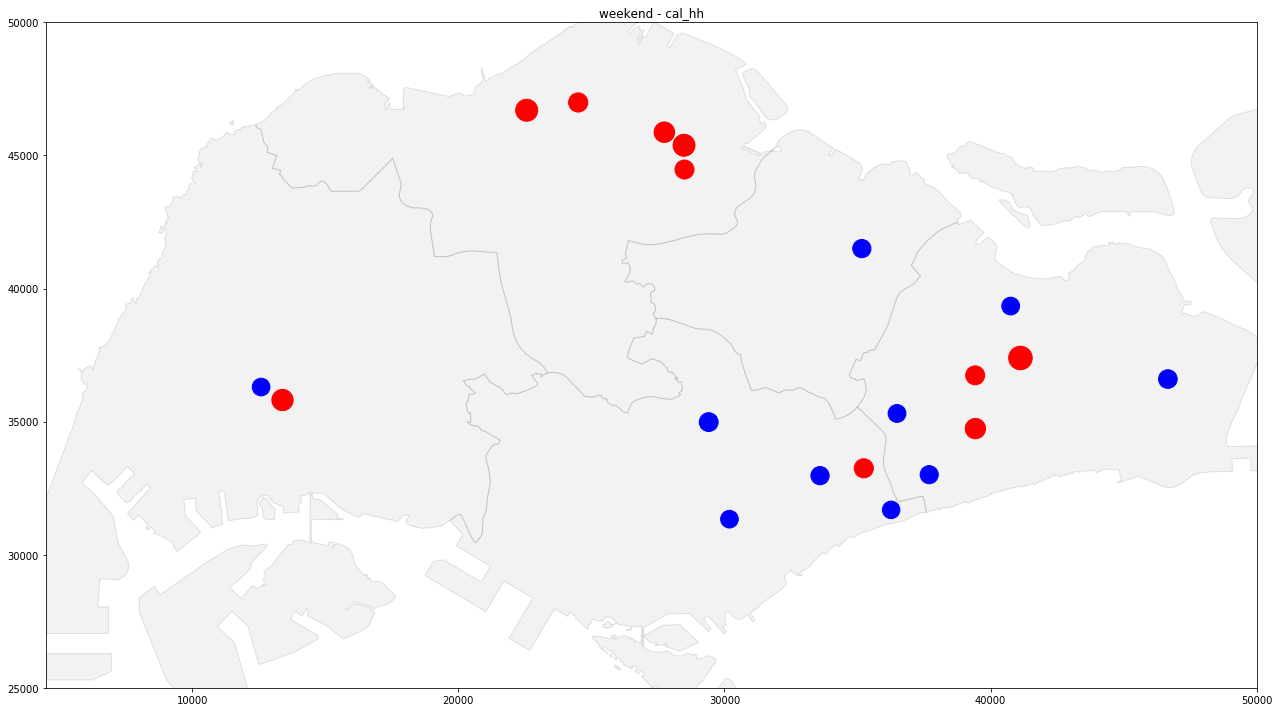

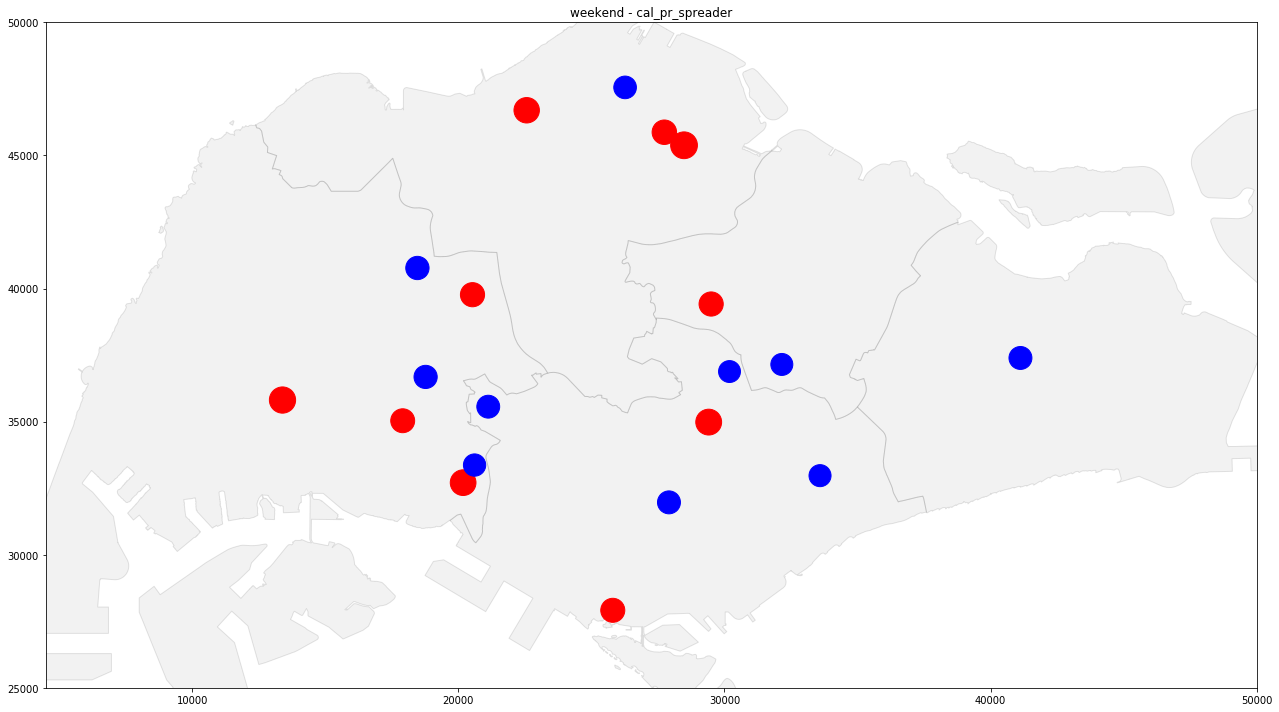

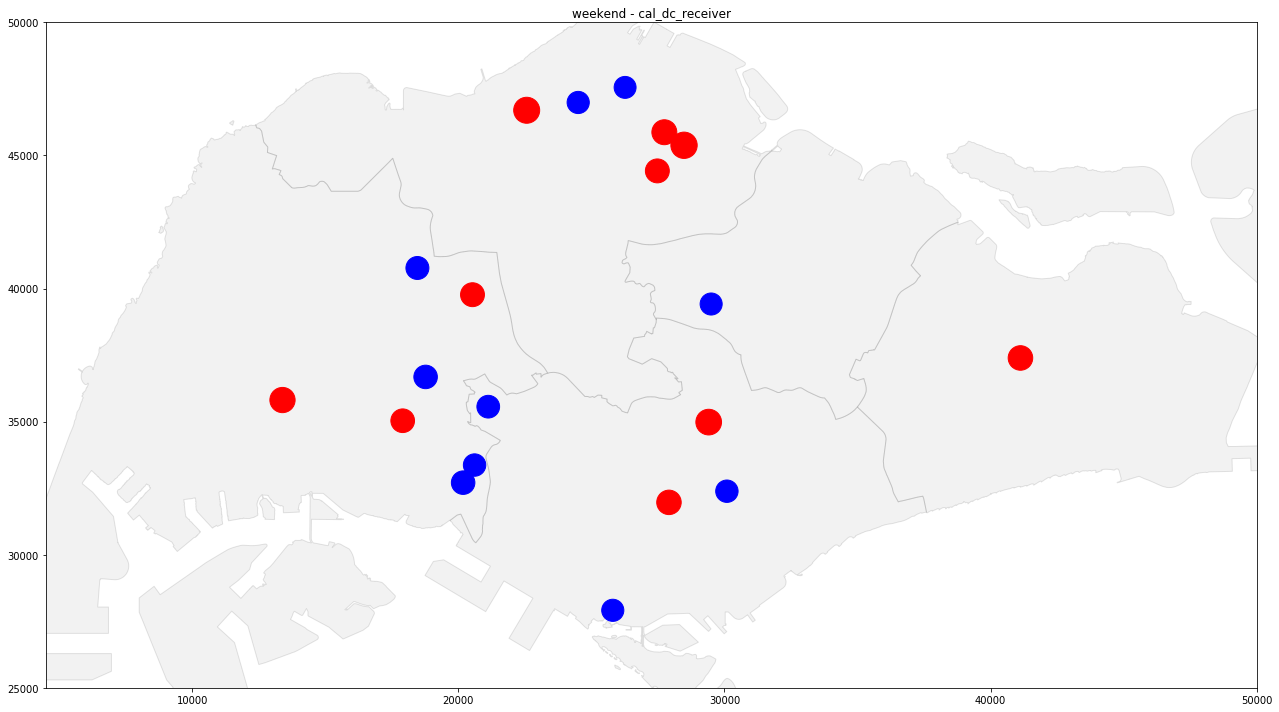

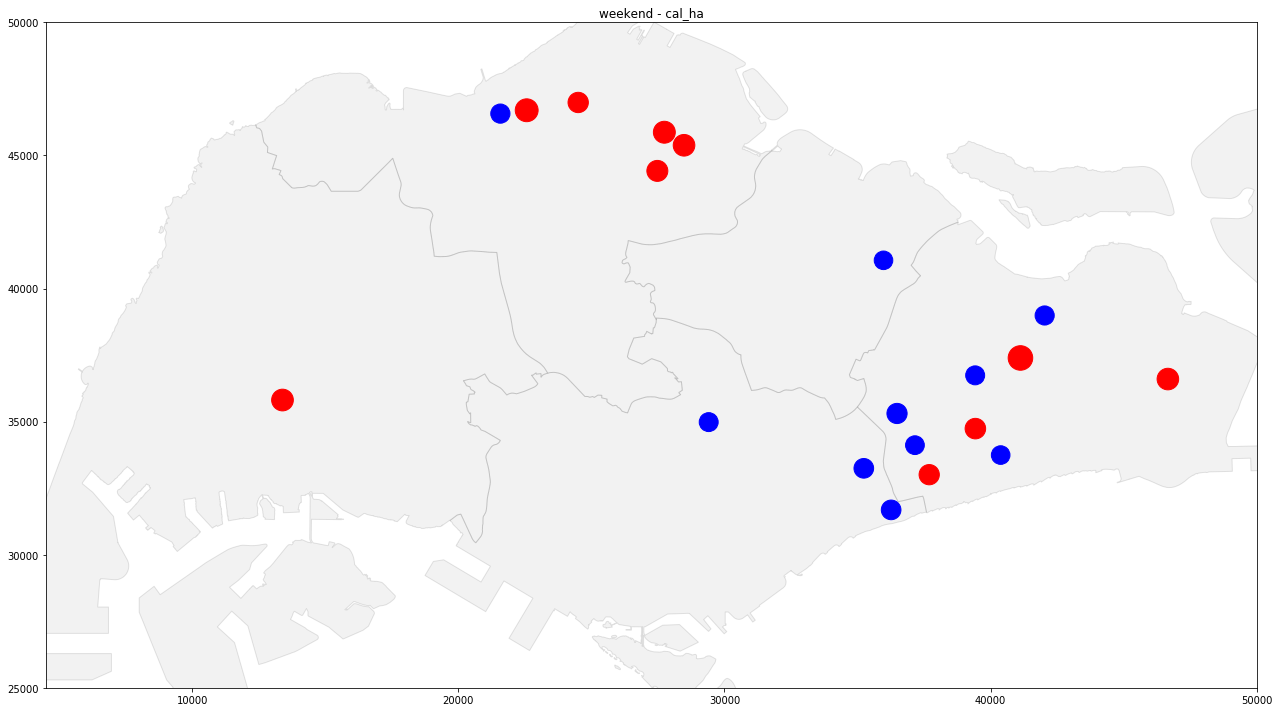

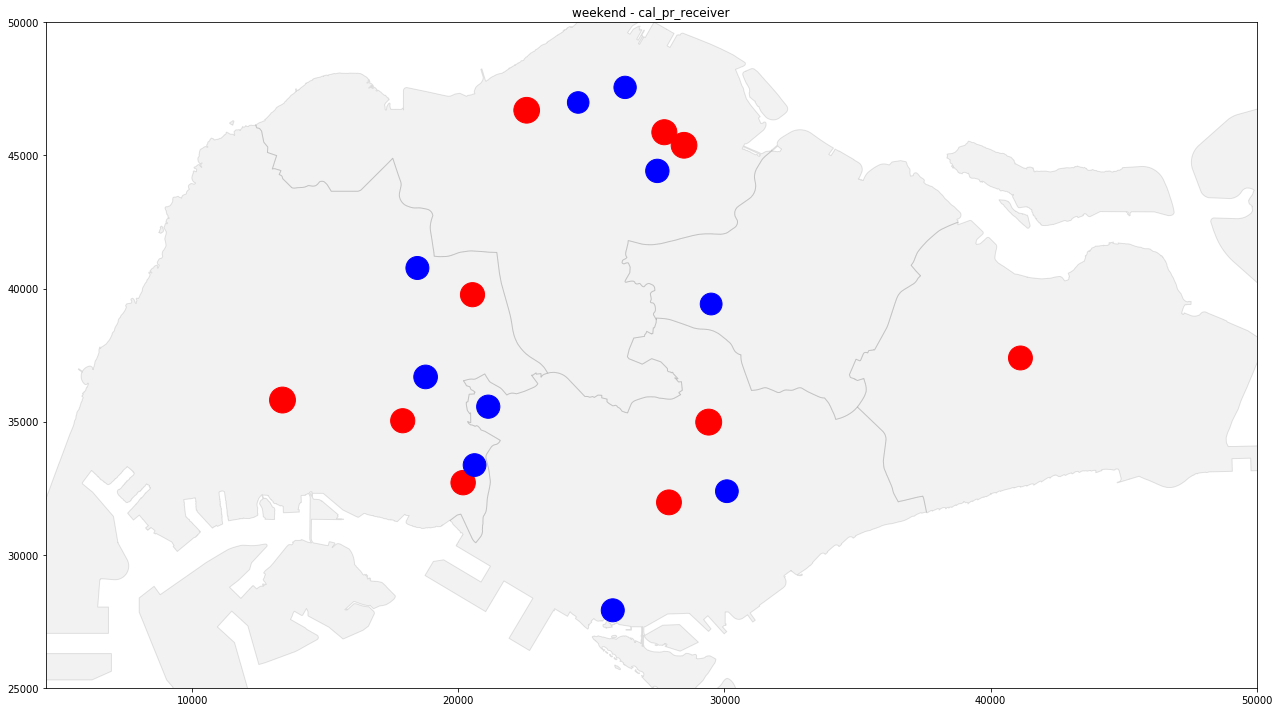

In [41]:
for col in [ col for col in weekend_res.columns if col!="node"]:
    draw_fig(weekend_res, col, top=10, top2=10, cat="weekend")

In [82]:
def draw_parallel(df, top=10, cols=None):
    if cols is None:
        cols = [ col for col in df.columns if col!="node"]
    top_nodes = set()
    nodes_val = {}
    for col in cols:
        nodes = get_top(df, col, top=top)
        nodes_val = {col: nodes}
        top_nodes = top_nodes | set([ n for n,v in nodes ])
    print(len(top_nodes), top_nodes)
    lines = []
    df2 = df.set_index("node")
    #print(df2.head())
    for n in top_nodes:
        line = []
        row = df2.loc[n]
        #print(row)
        for col in cols:
            line.append( row[col] )
        #print(line)
        lines.append(line)
        #break
    fig, ax = plt.subplots(figsize=(16,12))
    for line, n in zip(lines, top_nodes):
        ax.plot(line, label=n)
    for i in range(len(cols)):
        ax.axvline(x=i, ls=':', c='k')
    ax.set_xticks(list(range(len(cols))))
    ax.set_xticklabels(cols)
    ax.set_ylim([0,1])
    plt.legend()
    plt.tight_layout()

12 {'WOODLANDS REGIONAL CENTRE', 'YISHUN WEST', 'JELEBU', 'KHATIB', 'TOA PAYOH CENTRAL', 'YISHUN CENTRAL', 'JURONG WEST CENTRAL', 'JURONG GATEWAY', 'ALJUNIED', 'CHOA CHU KANG CENTRAL', 'TAMPINES EAST', 'YISHUN SOUTH'}


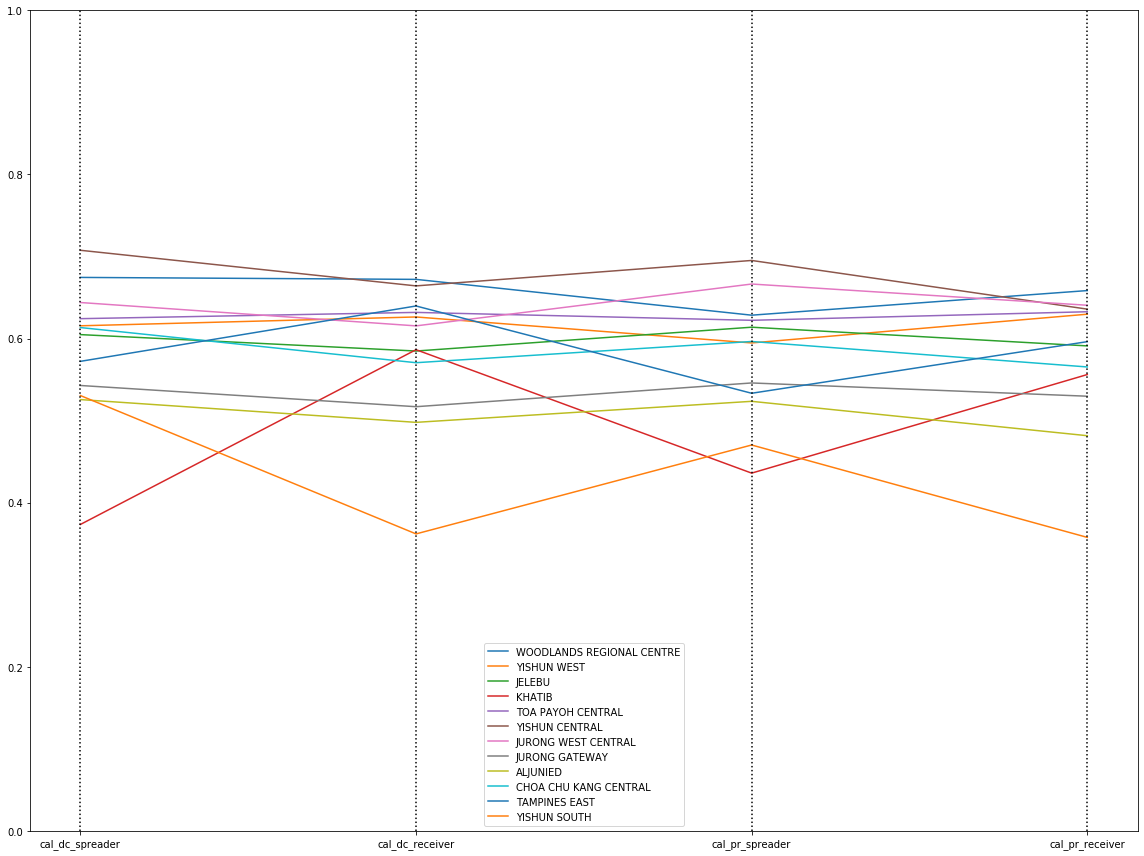

In [86]:
draw_parallel(weekday_res, top=10, cols=['cal_dc_spreader', 'cal_dc_receiver', 'cal_pr_spreader', 'cal_pr_receiver'])#, 'cal_hh',  'cal_ha'])

25 {'JELEBU', 'TOA PAYOH CENTRAL', 'JURONG GATEWAY', 'CLEMENTI CENTRAL', 'WOODLANDS EAST', 'MARITIME SQUARE', 'CHOA CHU KANG CENTRAL', 'YISHUN SOUTH', 'ANG MO KIO TOWN CENTRE', 'JOO KOON', 'WOODLANDS REGIONAL CENTRE', 'YISHUN WEST', 'KHATIB', 'CHANGI AIRPORT', 'WOODLANDS WEST', 'MATILDA', 'YISHUN CENTRAL', 'JURONG WEST CENTRAL', 'SEMBAWANG CENTRAL', 'SENGKANG TOWN CENTRE', 'ANAK BUKIT', 'ALJUNIED', 'UPPER THOMSON', 'TAMPINES EAST', 'BOULEVARD'}


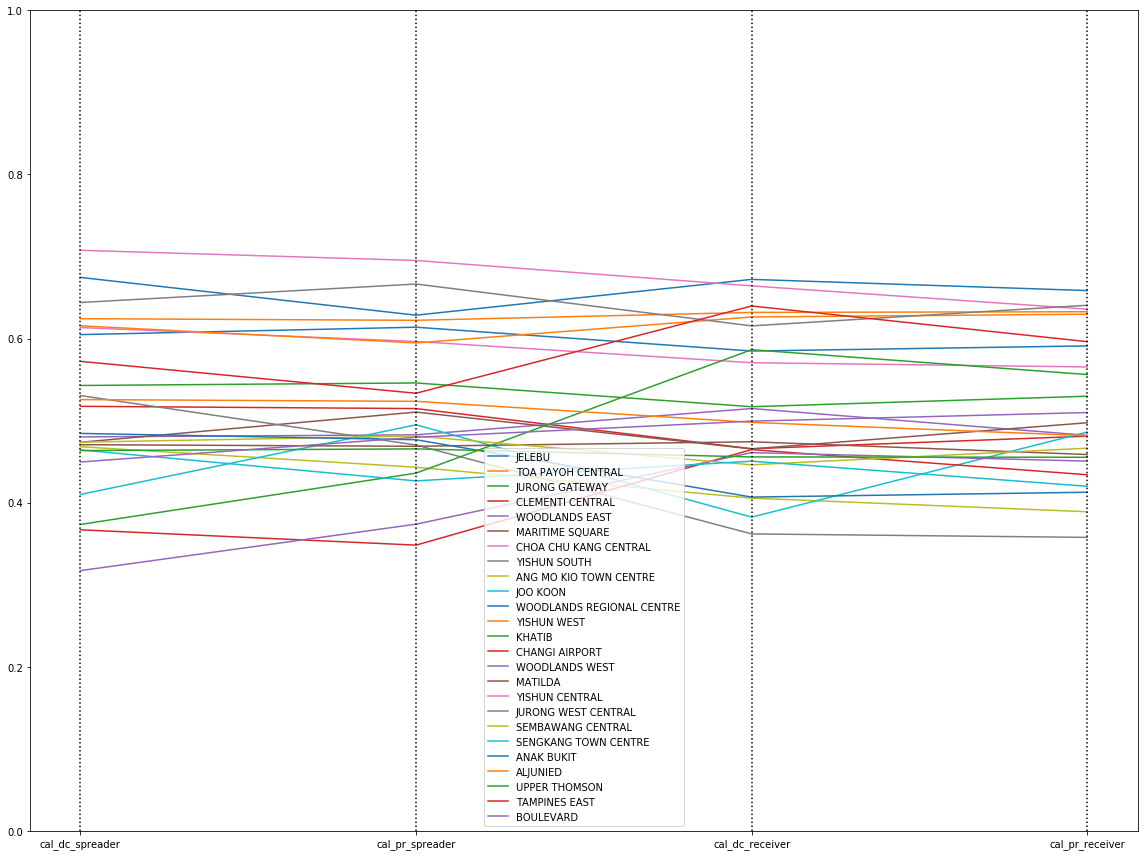

In [88]:
draw_parallel(weekday_res, top=20, cols=['cal_dc_spreader', 'cal_pr_spreader', 'cal_dc_receiver', 'cal_pr_receiver'])#, 'cal_hh',  'cal_ha'])

6 {'TOA PAYOH CENTRAL', 'WOODLANDS REGIONAL CENTRE', 'YISHUN CENTRAL', 'JURONG WEST CENTRAL', 'CLEMENTI CENTRAL', 'YISHUN WEST'}


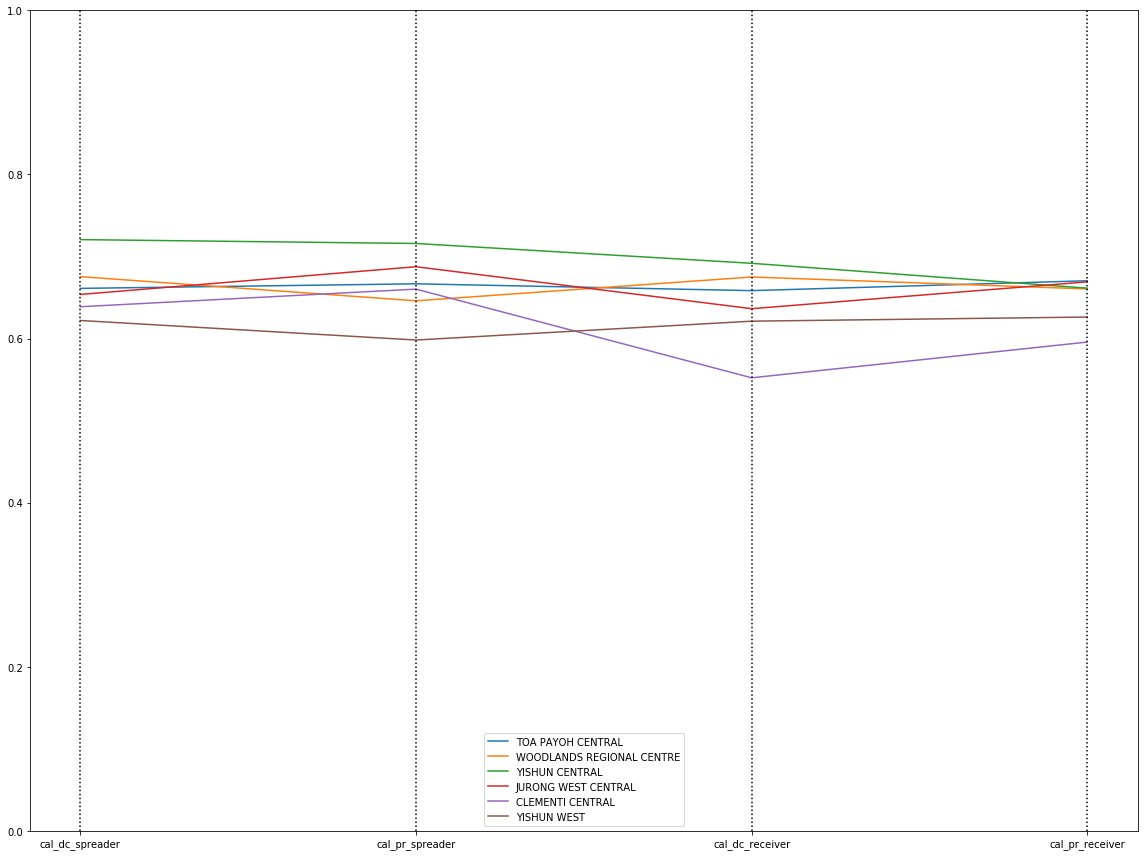

In [90]:
draw_parallel(weekend_res, top=5, cols=['cal_dc_spreader', 'cal_pr_spreader', 'cal_dc_receiver', 'cal_pr_receiver'])#, 'cal_hh',  'cal_ha'])

In [12]:
nodes = get_top(weekday_res, "cal_dc_spreader", top=10)
nodes

[('YISHUN CENTRAL', 0.7076367058909477),
 ('WOODLANDS REGIONAL CENTRE', 0.6745677061500274),
 ('JURONG WEST CENTRAL', 0.6439756655766382),
 ('TOA PAYOH CENTRAL', 0.6242768447492224),
 ('YISHUN WEST', 0.6156017032407197),
 ('CHOA CHU KANG CENTRAL', 0.6134705625087508),
 ('JELEBU', 0.6048607669712612),
 ('TAMPINES EAST', 0.5722755128032201),
 ('JURONG GATEWAY', 0.5428506261913704),
 ('YISHUN SOUTH', 0.5305800104939373)]

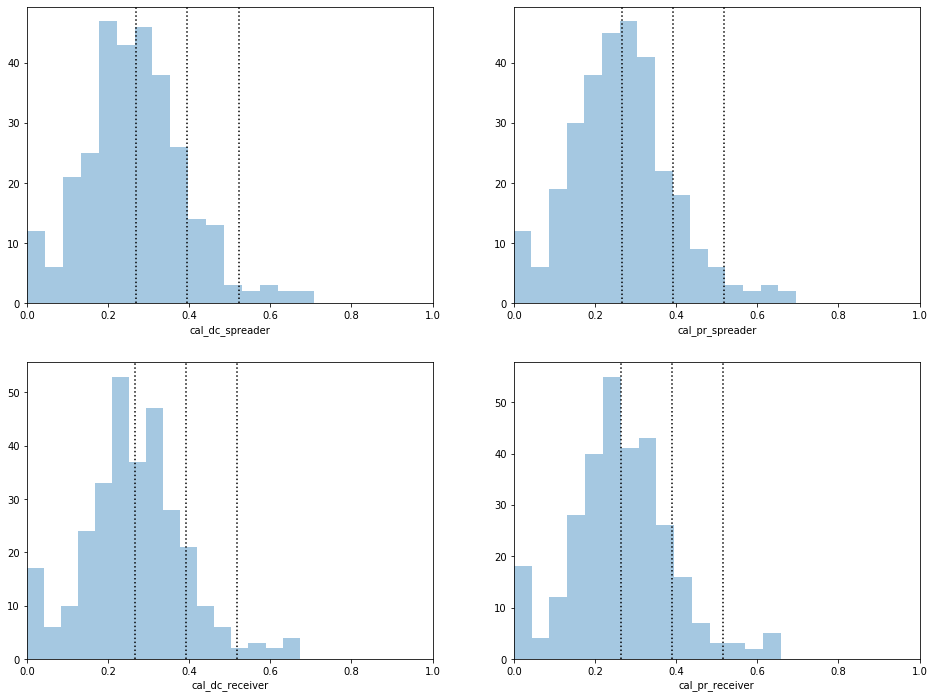

In [41]:
fig, axg = plt.subplots(2,2, figsize=(16,12))
axs = axg.flatten()
ax = axs[0]
sns.distplot(weekday_res["cal_dc_spreader"], kde=False, ax=ax)
ax.set_xlim([0,1])
ax.axvline(x=weekday_res["cal_dc_spreader"].mean(), ls=":", c="k")
ax.axvline(x=weekday_res["cal_dc_spreader"].mean()+2*weekday_res["cal_dc_spreader"].std(), ls=":", c="k")
ax.axvline(x=weekday_res["cal_dc_spreader"].mean()+1*weekday_res["cal_dc_spreader"].std(), ls=":", c="k")

ax = axs[1]
sns.distplot(weekday_res["cal_pr_spreader"], kde=False, ax=ax)
ax.set_xlim([0,1])
ax.axvline(x=weekday_res["cal_pr_spreader"].mean(), ls=":", c="k")
ax.axvline(x=weekday_res["cal_pr_spreader"].mean()+2*weekday_res["cal_pr_spreader"].std(), ls=":", c="k")
ax.axvline(x=weekday_res["cal_pr_spreader"].mean()+1*weekday_res["cal_pr_spreader"].std(), ls=":", c="k")

ax = axs[2]
sns.distplot(weekday_res["cal_dc_receiver"], kde=False, ax=ax)
ax.set_xlim([0,1])
ax.axvline(x=weekday_res["cal_dc_receiver"].mean(), ls=":", c="k")
ax.axvline(x=weekday_res["cal_dc_receiver"].mean()+2*weekday_res["cal_dc_receiver"].std(), ls=":", c="k")
ax.axvline(x=weekday_res["cal_dc_receiver"].mean()+1*weekday_res["cal_dc_receiver"].std(), ls=":", c="k")

ax = axs[3]
sns.distplot(weekday_res["cal_pr_receiver"], kde=False, ax=ax)
ax.set_xlim([0,1])
ax.axvline(x=weekday_res["cal_pr_receiver"].mean(), ls=":", c="k")
ax.axvline(x=weekday_res["cal_pr_receiver"].mean()+2*weekday_res["cal_pr_receiver"].std(), ls=":", c="k")
ax.axvline(x=weekday_res["cal_pr_receiver"].mean()+1*weekday_res["cal_pr_receiver"].std(), ls=":", c="k")

In [12]:
col = "cal_pr_receiver"

this_mean = weekday_res[col].mean()
this_std = weekday_res[col].std()
weekday_res[weekday_res[col]>=this_mean+2*this_std][["node", col]].sort_values(by=col, ascending=False)

,node,cal_pr_receiver
ind,,
235,WOODLANDS REGIONAL CENTRE,0.658525
259,JURONG WEST CENTRAL,0.640644
274,YISHUN CENTRAL,0.635924
2,TOA PAYOH CENTRAL,0.632736
275,YISHUN WEST,0.629735
0,TAMPINES EAST,0.596268
182,JELEBU,0.591101
283,CHOA CHU KANG CENTRAL,0.565437
276,KHATIB,0.556181


In [13]:
col = "cal_dc_receiver"

this_mean = weekday_res[col].mean()
this_std = weekday_res[col].std()
weekday_res[weekday_res[col]>=this_mean+2*this_std][["node", col]].sort_values(by=col, ascending=False)

,node,cal_dc_receiver
ind,,
235,WOODLANDS REGIONAL CENTRE,0.672186
274,YISHUN CENTRAL,0.664237
0,TAMPINES EAST,0.639755
2,TOA PAYOH CENTRAL,0.631936
275,YISHUN WEST,0.626365
259,JURONG WEST CENTRAL,0.615502
276,KHATIB,0.586478
182,JELEBU,0.584855
283,CHOA CHU KANG CENTRAL,0.570618


In [14]:
col = "cal_dc_spreader"

this_mean = weekday_res[col].mean()
this_std = weekday_res[col].std()
weekday_res[weekday_res[col]>=this_mean+2*this_std][["node", col]].sort_values(by=col, ascending=False)

,node,cal_dc_spreader
ind,,
274,YISHUN CENTRAL,0.707637
235,WOODLANDS REGIONAL CENTRE,0.674568
259,JURONG WEST CENTRAL,0.643976
2,TOA PAYOH CENTRAL,0.624277
275,YISHUN WEST,0.615602
283,CHOA CHU KANG CENTRAL,0.613471
182,JELEBU,0.604861
0,TAMPINES EAST,0.572276
180,JURONG GATEWAY,0.542851


In [15]:
col = "cal_pr_spreader"

this_mean = weekday_res[col].mean()
this_std = weekday_res[col].std()
weekday_res[weekday_res[col]>=this_mean+2*this_std][["node", col]].sort_values(by=col, ascending=False)

,node,cal_pr_spreader
ind,,
274,YISHUN CENTRAL,0.695236
259,JURONG WEST CENTRAL,0.666507
235,WOODLANDS REGIONAL CENTRE,0.628537
2,TOA PAYOH CENTRAL,0.622293
182,JELEBU,0.613883
283,CHOA CHU KANG CENTRAL,0.596475
275,YISHUN WEST,0.594715
180,JURONG GATEWAY,0.545937
0,TAMPINES EAST,0.533376


In [38]:
def get_top(df, col, times_std=2):
    this_mean = df[col].mean()
    this_std = df[col].std()
    return df[df[col]>=this_mean+times_std*this_std][["node", col]].sort_values(by=col, ascending=False)


def get_top_2levels(df, col):
    this_mean = df[col].mean()
    this_std = df[col].std()
    top_2sd = df[df[col]>=this_mean+2*this_std][["node", col]].sort_values(by=col, ascending=False)
    top_1sd = df[df[col]>=this_mean+1*this_std][["node", col]].sort_values(by=col, ascending=False)
    top_1sd["top"] = 2
    for i in top_2sd.index:
        #print(i)
        top_1sd.at[i,"top"] = 1
    #print(top_1sd)
    return top_1sd
    

def get_pos(nodes, pos):
    xs = []
    ys = []
    for n in nodes:
        x,y = pos[n]
        xs.append(x)
        ys.append(y)
    return xs, ys



In [40]:
#get_top_2levels(weekday_res, "cal_pr_spreader")

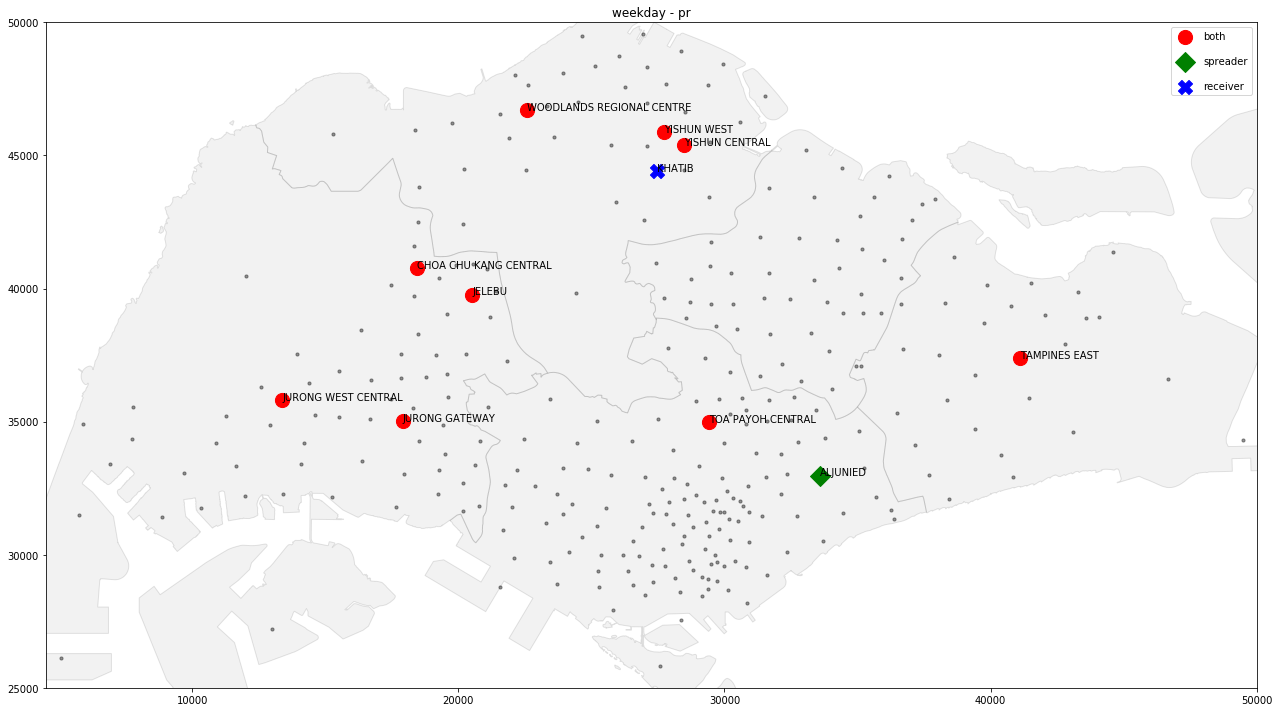

In [102]:
fig, ax = plt.subplots(figsize=(20,10))

col_method = "pr"
day = "weekday"
this_df = weekday_res
spread_col = "cal_{}_spreader".format(col_method)
receiv_col = "cal_{}_receiver".format(col_method)

region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)

top_df_out = get_top(this_df, spread_col, times_std=2.)
top_df_inc = get_top(this_df, receiv_col, times_std=2.)
out_nodes = set(top_df_out["node"].tolist())
inc_nodes = set(top_df_inc["node"].tolist())

both = list(out_nodes.intersection(inc_nodes))
out_only = list(out_nodes.difference(inc_nodes))
inc_only = list(inc_nodes.difference(out_nodes))

xs_both, ys_both = get_pos(both, pos)
xs_out, ys_out = get_pos(out_only, pos)
xs_inc, ys_inc = get_pos(inc_only, pos)

ax.scatter(xs_both, ys_both, s=200, c="red", label="both", zorder=3, marker="o")
ax.scatter(xs_out, ys_out, s=200, c="green", label="spreader", zorder=3, marker="D")
ax.scatter(xs_inc, ys_inc, s=200, c="blue", label="receiver", zorder=3, marker="X")
ax.scatter([x for n,(x,y) in pos.items() ], [y for n,(x,y) in pos.items() ], s=10, c="k", zorder=2, alpha=.4)

all_nodes = list(out_nodes | inc_nodes)
xs_all, ys_all = get_pos(all_nodes, pos)
for i, txt in enumerate(all_nodes):
    ax.annotate(txt, (xs_all[i], ys_all[i]))
    
ax.legend(labelspacing=1.5, )
ax.set_title("{} - {}".format(day, col_method))
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()
plt.savefig("figs/superSR-{}-{}.png".format(day, col_method), dpi=100, bbox_inches="tight")

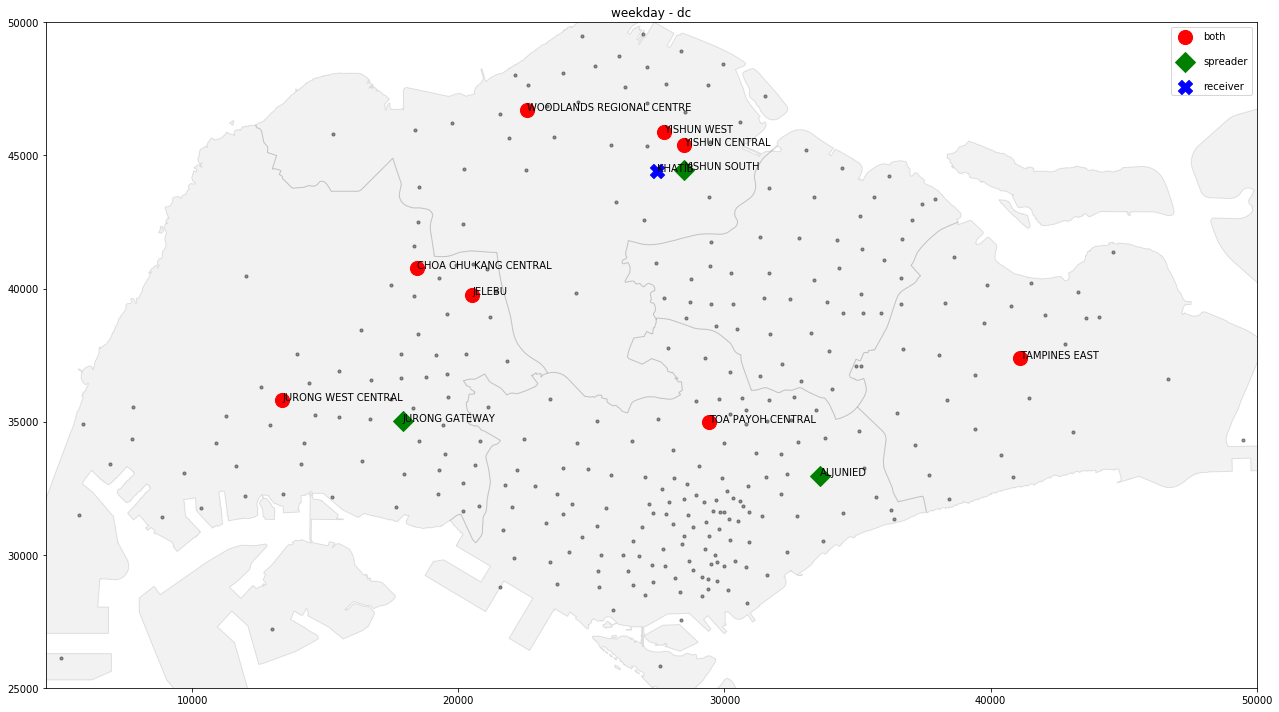

In [103]:
fig, ax = plt.subplots(figsize=(20,10))

col_method = "dc"
day = "weekday"
this_df = weekday_res
spread_col = "cal_{}_spreader".format(col_method)
receiv_col = "cal_{}_receiver".format(col_method)

region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)

top_df_out = get_top(this_df, spread_col, times_std=2.)
top_df_inc = get_top(this_df, receiv_col, times_std=2.)
out_nodes = set(top_df_out["node"].tolist())
inc_nodes = set(top_df_inc["node"].tolist())

both = list(out_nodes.intersection(inc_nodes))
out_only = list(out_nodes.difference(inc_nodes))
inc_only = list(inc_nodes.difference(out_nodes))

xs_both, ys_both = get_pos(both, pos)
xs_out, ys_out = get_pos(out_only, pos)
xs_inc, ys_inc = get_pos(inc_only, pos)

ax.scatter(xs_both, ys_both, s=200, c="red", label="both", zorder=3, marker="o")
ax.scatter(xs_out, ys_out, s=200, c="green", label="spreader", zorder=3, marker="D")
ax.scatter(xs_inc, ys_inc, s=200, c="blue", label="receiver", zorder=3, marker="X")
ax.scatter([x for n,(x,y) in pos.items() ], [y for n,(x,y) in pos.items() ], s=10, c="k", zorder=2, alpha=.4)

all_nodes = list(out_nodes | inc_nodes)
xs_all, ys_all = get_pos(all_nodes, pos)
for i, txt in enumerate(all_nodes):
    ax.annotate(txt, (xs_all[i], ys_all[i]))

ax.legend(labelspacing=1.5, )
ax.set_title("{} - {}".format(day, col_method))
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()
plt.savefig("figs/superSR-{}-{}.png".format(day, col_method), dpi=100, bbox_inches="tight")

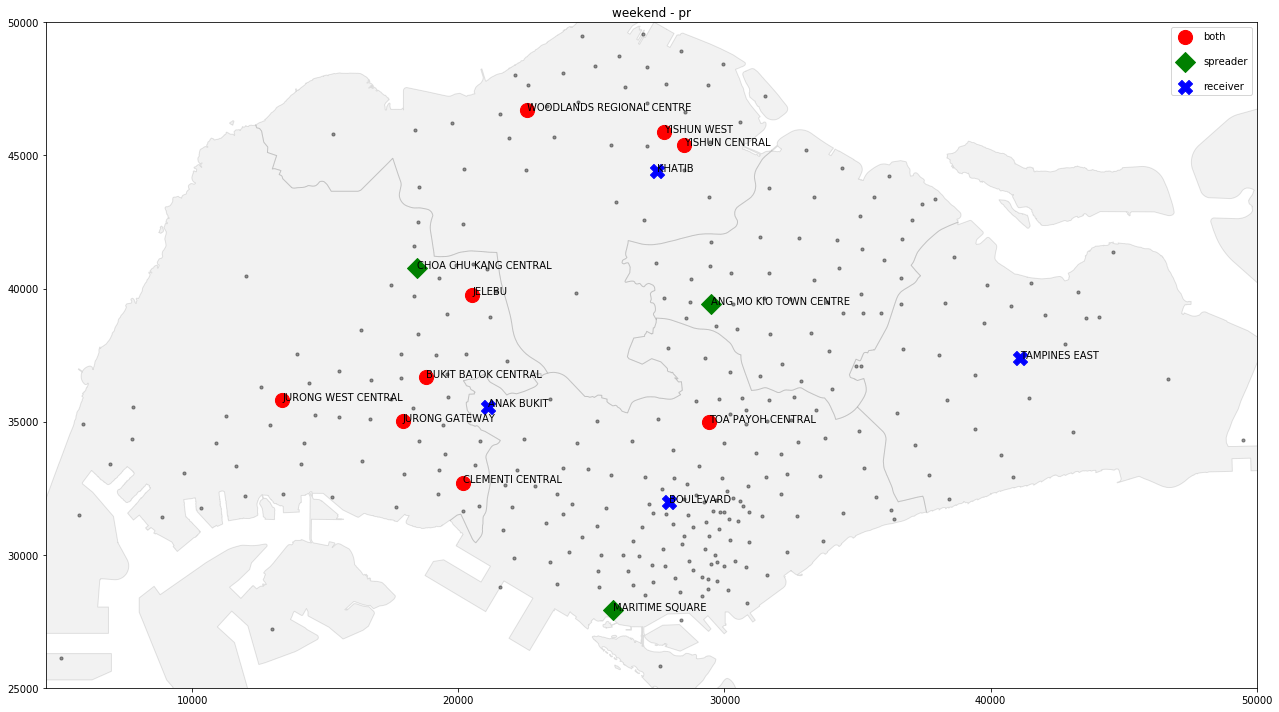

In [104]:
fig, ax = plt.subplots(figsize=(20,10))

col_method = "pr"
day = "weekend"
this_df = weekend_res
spread_col = "cal_{}_spreader".format(col_method)
receiv_col = "cal_{}_receiver".format(col_method)

region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)

top_df_out = get_top(this_df, spread_col, times_std=2.)
top_df_inc = get_top(this_df, receiv_col, times_std=2.)
out_nodes = set(top_df_out["node"].tolist())
inc_nodes = set(top_df_inc["node"].tolist())

both = list(out_nodes.intersection(inc_nodes))
out_only = list(out_nodes.difference(inc_nodes))
inc_only = list(inc_nodes.difference(out_nodes))

xs_both, ys_both = get_pos(both, pos)
xs_out, ys_out = get_pos(out_only, pos)
xs_inc, ys_inc = get_pos(inc_only, pos)

ax.scatter(xs_both, ys_both, s=200, c="red", label="both", zorder=3, marker="o")
ax.scatter(xs_out, ys_out, s=200, c="green", label="spreader", zorder=3, marker="D")
ax.scatter(xs_inc, ys_inc, s=200, c="blue", label="receiver", zorder=3, marker="X")
ax.scatter([x for n,(x,y) in pos.items() ], [y for n,(x,y) in pos.items() ], s=10, c="k", zorder=2, alpha=.4)

all_nodes = list(out_nodes | inc_nodes)
xs_all, ys_all = get_pos(all_nodes, pos)
for i, txt in enumerate(all_nodes):
    ax.annotate(txt, (xs_all[i], ys_all[i]))
    
ax.legend(labelspacing=1.5, )
ax.set_title("{} - {}".format(day, col_method))
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()
plt.savefig("figs/superSR-{}-{}.png".format(day, col_method), dpi=100, bbox_inches="tight")

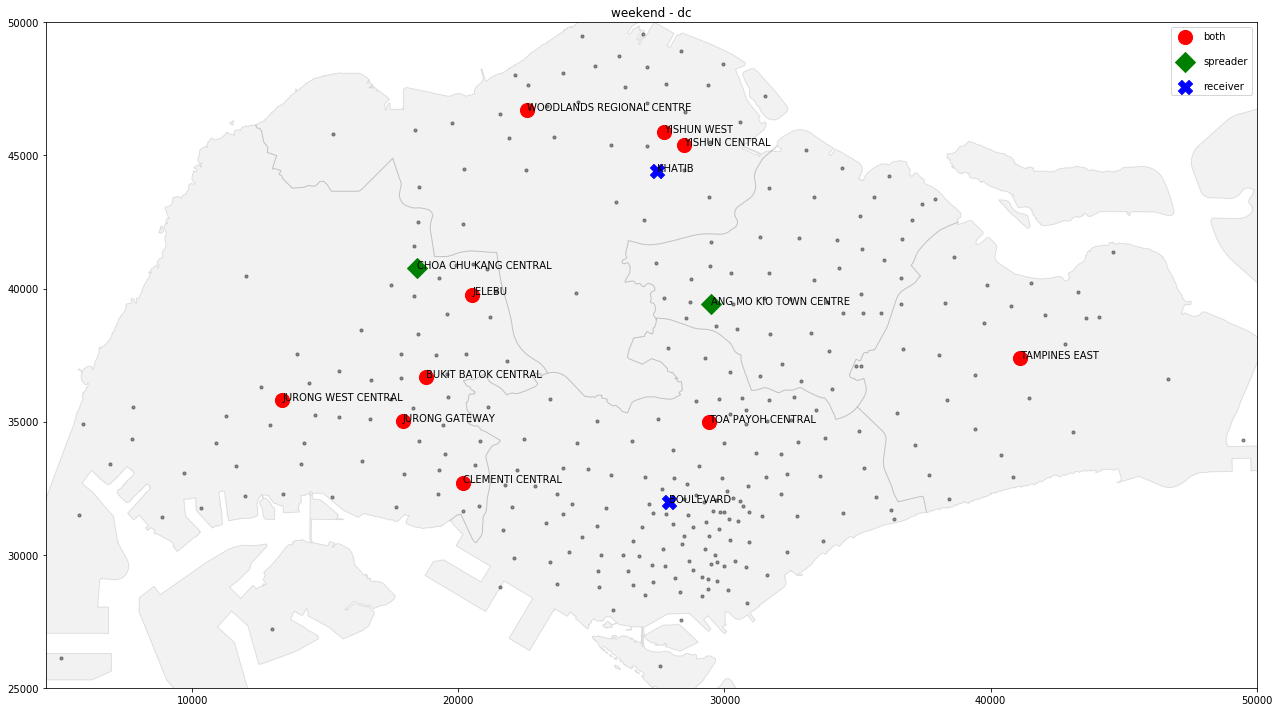

In [105]:
fig, ax = plt.subplots(figsize=(20,10))

col_method = "dc"
day = "weekend"
this_df = weekend_res
spread_col = "cal_{}_spreader".format(col_method)
receiv_col = "cal_{}_receiver".format(col_method)

region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)

top_df_out = get_top(this_df, spread_col, times_std=2.)
top_df_inc = get_top(this_df, receiv_col, times_std=2.)
out_nodes = set(top_df_out["node"].tolist())
inc_nodes = set(top_df_inc["node"].tolist())

both = list(out_nodes.intersection(inc_nodes))
out_only = list(out_nodes.difference(inc_nodes))
inc_only = list(inc_nodes.difference(out_nodes))

xs_both, ys_both = get_pos(both, pos)
xs_out, ys_out = get_pos(out_only, pos)
xs_inc, ys_inc = get_pos(inc_only, pos)

ax.scatter(xs_both, ys_both, s=200, c="red", label="both", zorder=3, marker="o")
ax.scatter(xs_out, ys_out, s=200, c="green", label="spreader", zorder=3, marker="D")
ax.scatter(xs_inc, ys_inc, s=200, c="blue", label="receiver", zorder=3, marker="X")
ax.scatter([x for n,(x,y) in pos.items() ], [y for n,(x,y) in pos.items() ], s=10, c="k", zorder=2, alpha=.4)

all_nodes = list(out_nodes | inc_nodes)
xs_all, ys_all = get_pos(all_nodes, pos)
for i, txt in enumerate(all_nodes):
    ax.annotate(txt, (xs_all[i], ys_all[i]))

ax.legend(labelspacing=1.5, )
ax.set_title("{} - {}".format(day, col_method))
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()
plt.savefig("figs/superSR-{}-{}.png".format(day, col_method), dpi=100, bbox_inches="tight")

In [76]:
df_merge = pd.merge(get_top_2levels(weekday_res, "cal_dc_spreader"), get_top_2levels(weekday_res, "cal_dc_receiver"), left_on="node", right_on="node", how="outer")#.sort_values(by=["top_x", "top_y"])
df_merge#[pd.isnull(df_merge["top_x"])]

,node,cal_dc_spreader,top_x,cal_dc_receiver,top_y
0,YISHUN CENTRAL,0.707637,1.0,0.664237,1.0
1,WOODLANDS REGIONAL CENTRE,0.674568,1.0,0.672186,1.0
2,JURONG WEST CENTRAL,0.643976,1.0,0.615502,1.0
3,TOA PAYOH CENTRAL,0.624277,1.0,0.631936,1.0
4,YISHUN WEST,0.615602,1.0,0.626365,1.0
5,CHOA CHU KANG CENTRAL,0.613471,1.0,0.570618,1.0
6,JELEBU,0.604861,1.0,0.584855,1.0
7,TAMPINES EAST,0.572276,1.0,0.639755,1.0
8,JURONG GATEWAY,0.542851,1.0,0.516996,2.0
9,YISHUN SOUTH,0.530580,1.0,NaN,NaN


In [77]:
weekday_res.head()

,node,cal_dc_spreader,cal_hh,cal_pr_spreader,cal_dc_receiver,cal_ha,cal_pr_receiver
ind,,,,,,,
0,TAMPINES EAST,0.572276,0.572276,0.533376,0.639755,0.635740,0.596268
1,BEDOK NORTH,0.360342,0.337404,0.338292,0.362057,0.340500,0.336666
2,TOA PAYOH CENTRAL,0.624277,0.303357,0.622293,0.631936,0.310269,0.632736
3,ALJUNIED,0.525679,0.322300,0.523547,0.497914,0.331237,0.481654
4,TAMPINES WEST,0.394065,0.431569,0.371555,0.322927,0.394873,0.295054


In [82]:
cols = [col for col in weekday_res.columns if not(col=="node")]
cols2 = []
lvl_cols = {}
for col in cols:
    this_col = weekday_res[col]
    this_mean = this_col.mean()
    this_std = this_col.std()
    lvl = []
    for v in this_col:
        if v>=this_mean+2*this_std:
            lvl.append(1)
        elif v>=this_mean+this_std:
            lvl.append(2)
        else:
            lvl.append(3)
    new_col = col.replace("cal", "lvl")
    lvl_cols[new_col] = lvl
    cols2.append(new_col)
    
lvl_cols.update({"node": weekday_res["node"]})
lvl_res = pd.DataFrame.from_dict(lvl_cols)
lvl_res = lvl_res[["node"]+cols2]
lvl_res.head()

,node,lvl_dc_spreader,lvl_hh,lvl_pr_spreader,lvl_dc_receiver,lvl_ha,lvl_pr_receiver
ind,,,,,,,
0,TAMPINES EAST,1,1,1,1,1,1
1,BEDOK NORTH,3,1,3,3,1,3
2,TOA PAYOH CENTRAL,1,2,1,1,2,1
3,ALJUNIED,1,1,1,2,1,2
4,TAMPINES WEST,3,1,3,3,1,3


In [84]:
lvl_res.to_csv("Super_SR_lvl_weekday.csv", index_label="ind")

In [86]:
cols = [col for col in weekend_res.columns if not(col=="node")]
cols2 = []
lvl_cols = {}
for col in cols:
    this_col = weekend_res[col]
    this_mean = this_col.mean()
    this_std = this_col.std()
    lvl = []
    for v in this_col:
        if v>=this_mean+2*this_std:
            lvl.append(1)
        elif v>=this_mean+this_std:
            lvl.append(2)
        else:
            lvl.append(3)
    new_col = col.replace("cal", "lvl")
    lvl_cols[new_col] = lvl
    cols2.append(new_col)
    
lvl_cols.update({"node": weekend_res["node"]})
lvl_res = pd.DataFrame.from_dict(lvl_cols)
lvl_res = lvl_res[["node"]+cols2]
lvl_res.head()

,node,lvl_dc_spreader,lvl_hh,lvl_pr_spreader,lvl_dc_receiver,lvl_ha,lvl_pr_receiver
ind,,,,,,,
0,TAMPINES EAST,1,1,2,1,1,1
1,BEDOK NORTH,2,1,2,2,1,2
2,TOA PAYOH CENTRAL,1,1,1,1,2,1
3,ALJUNIED,2,2,2,2,2,2
4,TAMPINES WEST,3,1,3,3,2,3


In [87]:
lvl_res.to_csv("Super_SR_lvl_weekend.csv", index_label="ind")

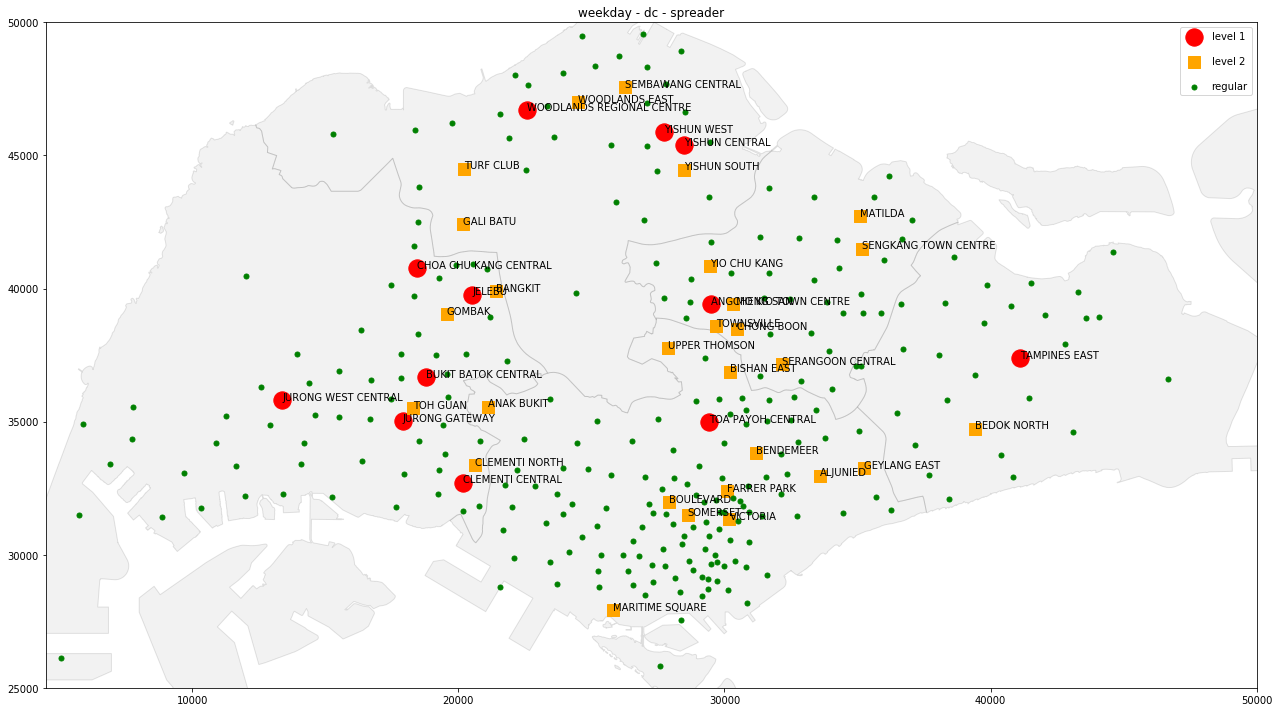

In [107]:

fig, ax = plt.subplots(figsize=(20,10))

col_method = "dc"
direction = "spreader"
day = "weekday"
this_df = weekday_res
this_col = "lvl_{}_{}".format(col_method, direction)

region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)

lvl_res

lvl1 = lvl_res[lvl_res[this_col]==1]["node"].tolist()
lvl2 = lvl_res[lvl_res[this_col]==2]["node"].tolist()
lvl3 = lvl_res[lvl_res[this_col]==3]["node"].tolist()

xs_1, ys_1 = get_pos(lvl1, pos)
xs_2, ys_2 = get_pos(lvl2, pos)
xs_3, ys_3 = get_pos(lvl3, pos)

ax.scatter(xs_1, ys_1, s=300, c="red", label="level 1", zorder=3, marker="o")
ax.scatter(xs_2, ys_2, s=150, c="orange", label="level 2", zorder=3, marker="s")
ax.scatter(xs_3, ys_3, s=100, c="green", label="regular", zorder=3, marker=".")
#ax.scatter([x for n,(x,y) in pos.items() ], [y for n,(x,y) in pos.items() ], s=10, c="k", zorder=2, alpha=.4)

all_nodes = set(lvl1) | set(lvl2)
xs_all, ys_all = get_pos(all_nodes, pos)
for i, txt in enumerate(all_nodes):
    ax.annotate(txt, (xs_all[i], ys_all[i]))

ax.legend(labelspacing=1.5, )
ax.set_title("{} - {} - {}".format(day, col_method, direction))
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()
plt.savefig("figs/val_dist-{}-{}.png".format(day, col_method), dpi=100, bbox_inches="tight")


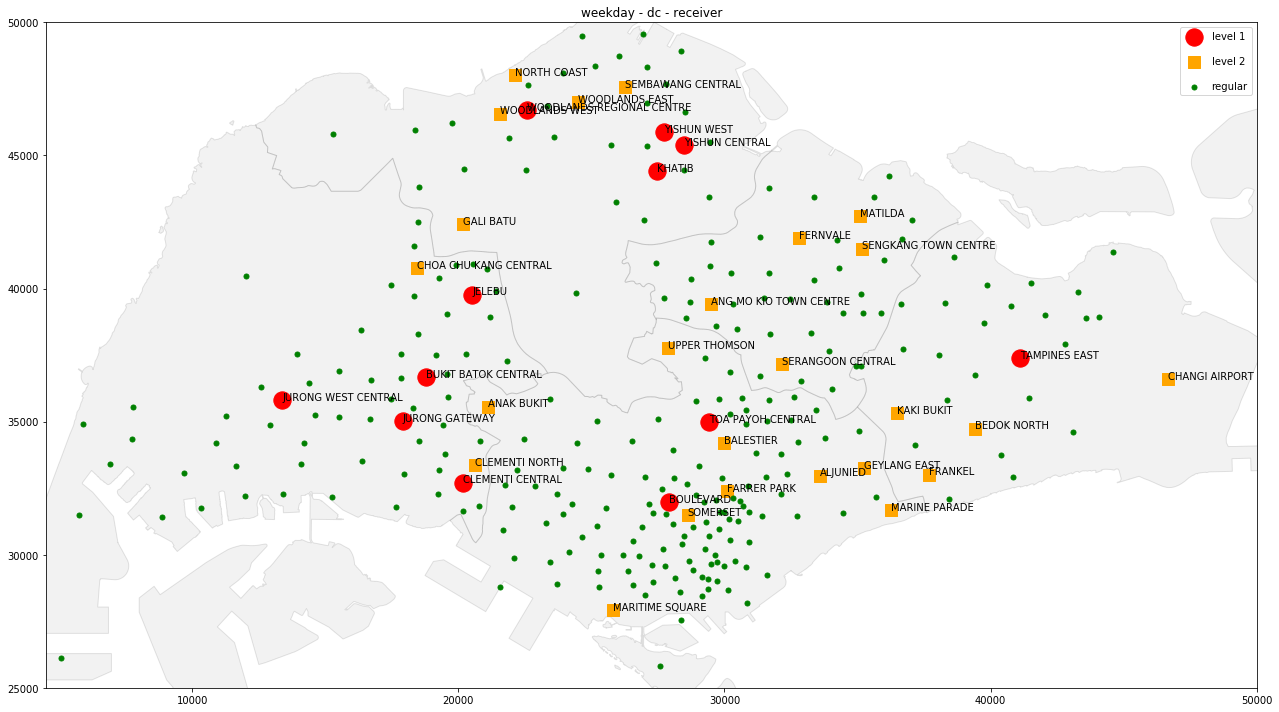

In [106]:

fig, ax = plt.subplots(figsize=(20,10))

col_method = "dc"
direction = "receiver"
day = "weekday"
this_df = weekday_res
this_col = "lvl_{}_{}".format(col_method, direction)

region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)

lvl_res

lvl1 = lvl_res[lvl_res[this_col]==1]["node"].tolist()
lvl2 = lvl_res[lvl_res[this_col]==2]["node"].tolist()
lvl3 = lvl_res[lvl_res[this_col]==3]["node"].tolist()

xs_1, ys_1 = get_pos(lvl1, pos)
xs_2, ys_2 = get_pos(lvl2, pos)
xs_3, ys_3 = get_pos(lvl3, pos)

ax.scatter(xs_1, ys_1, s=300, c="red", label="level 1", zorder=3, marker="o")
ax.scatter(xs_2, ys_2, s=150, c="orange", label="level 2", zorder=3, marker="s")
ax.scatter(xs_3, ys_3, s=100, c="green", label="regular", zorder=3, marker=".")
#ax.scatter([x for n,(x,y) in pos.items() ], [y for n,(x,y) in pos.items() ], s=10, c="k", zorder=2, alpha=.4)

all_nodes = set(lvl1) | set(lvl2)
xs_all, ys_all = get_pos(all_nodes, pos)
for i, txt in enumerate(all_nodes):
    ax.annotate(txt, (xs_all[i], ys_all[i]))

ax.legend(labelspacing=1.5, )
ax.set_title("{} - {} - {}".format(day, col_method, direction))
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()
plt.savefig("figs/val_dist-{}-{}-{}.png".format(day, col_method, direction), dpi=100, bbox_inches="tight")


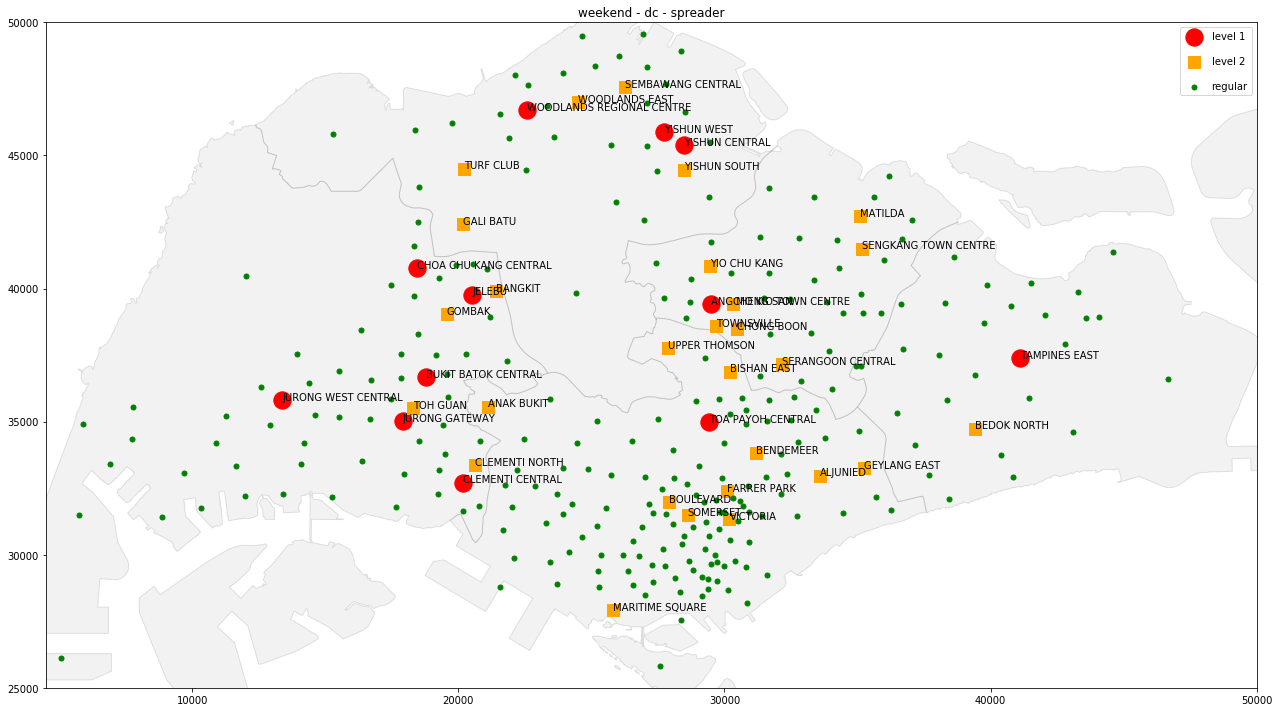

In [108]:

fig, ax = plt.subplots(figsize=(20,10))

col_method = "dc"
direction = "spreader"
day = "weekend"
this_df = weekend_res
this_col = "lvl_{}_{}".format(col_method, direction)

region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)

lvl_res

lvl1 = lvl_res[lvl_res[this_col]==1]["node"].tolist()
lvl2 = lvl_res[lvl_res[this_col]==2]["node"].tolist()
lvl3 = lvl_res[lvl_res[this_col]==3]["node"].tolist()

xs_1, ys_1 = get_pos(lvl1, pos)
xs_2, ys_2 = get_pos(lvl2, pos)
xs_3, ys_3 = get_pos(lvl3, pos)

ax.scatter(xs_1, ys_1, s=300, c="red", label="level 1", zorder=3, marker="o")
ax.scatter(xs_2, ys_2, s=150, c="orange", label="level 2", zorder=3, marker="s")
ax.scatter(xs_3, ys_3, s=100, c="green", label="regular", zorder=3, marker=".")
#ax.scatter([x for n,(x,y) in pos.items() ], [y for n,(x,y) in pos.items() ], s=10, c="k", zorder=2, alpha=.4)

all_nodes = set(lvl1) | set(lvl2)
xs_all, ys_all = get_pos(all_nodes, pos)
for i, txt in enumerate(all_nodes):
    ax.annotate(txt, (xs_all[i], ys_all[i]))

ax.legend(labelspacing=1.5, )
ax.set_title("{} - {} - {}".format(day, col_method, direction))
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()
plt.savefig("figs/val_dist-{}-{}-{}.png".format(day, col_method, direction), dpi=100, bbox_inches="tight")


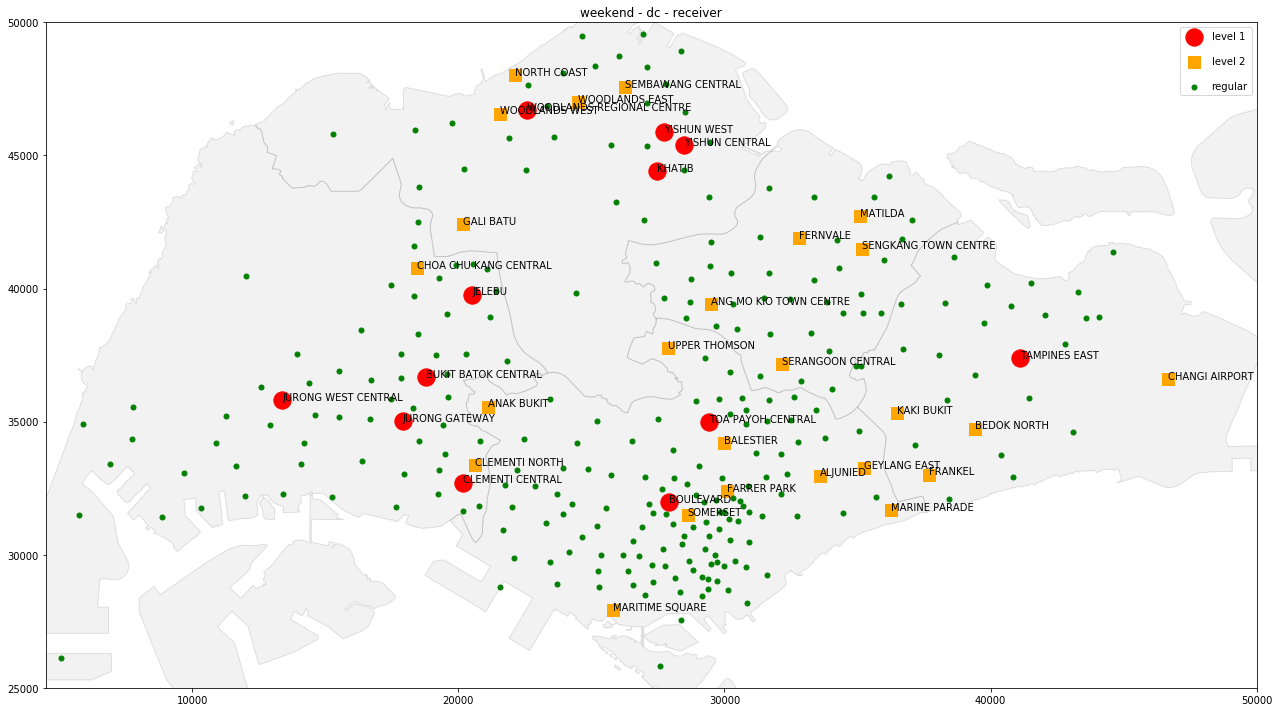

In [109]:

fig, ax = plt.subplots(figsize=(20,10))

col_method = "dc"
direction = "receiver"
day = "weekend"
this_df = weekend_res
this_col = "lvl_{}_{}".format(col_method, direction)

region.plot(ax=ax, color="grey", edgecolor="k", alpha=0.1)

lvl_res

lvl1 = lvl_res[lvl_res[this_col]==1]["node"].tolist()
lvl2 = lvl_res[lvl_res[this_col]==2]["node"].tolist()
lvl3 = lvl_res[lvl_res[this_col]==3]["node"].tolist()

xs_1, ys_1 = get_pos(lvl1, pos)
xs_2, ys_2 = get_pos(lvl2, pos)
xs_3, ys_3 = get_pos(lvl3, pos)

ax.scatter(xs_1, ys_1, s=300, c="red", label="level 1", zorder=3, marker="o")
ax.scatter(xs_2, ys_2, s=150, c="orange", label="level 2", zorder=3, marker="s")
ax.scatter(xs_3, ys_3, s=100, c="green", label="regular", zorder=3, marker=".")
#ax.scatter([x for n,(x,y) in pos.items() ], [y for n,(x,y) in pos.items() ], s=10, c="k", zorder=2, alpha=.4)

all_nodes = set(lvl1) | set(lvl2)
xs_all, ys_all = get_pos(all_nodes, pos)
for i, txt in enumerate(all_nodes):
    ax.annotate(txt, (xs_all[i], ys_all[i]))

ax.legend(labelspacing=1.5, )
ax.set_title("{} - {} - {}".format(day, col_method, direction))
ax.set_xlim([4500,50000])
ax.set_ylim([25000,50000])
plt.tight_layout()
plt.savefig("figs/val_dist-{}-{}-{}.png".format(day, col_method, direction), dpi=100, bbox_inches="tight")


In [45]:
def draw_parallel(df, top_nodes, cols=None):
    if cols is None:
        cols = [ col for col in df.columns if col!="node"]
    lines = []
    df2 = df.set_index("node")
    #print(df2.head())
    for n in top_nodes:
        line = []
        row = df2.loc[n]
        #print(row)
        for col in cols:
            line.append( row[col] )
        #print(line)
        lines.append(line)
        #break
    fig, ax = plt.subplots(figsize=(16,12))
    for line, n in zip(lines, top_nodes):
        ax.plot(line, label=n)
    for i in range(len(cols)):
        ax.axvline(x=i, ls=':', c='k')
    ax.set_xticks(list(range(len(cols))))
    ax.set_xticklabels(cols)
    ax.set_ylim([0,1])
    plt.legend()
    plt.tight_layout()